В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [21]:
from sklearn.metrics import roc_curve, auc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any

import warnings
warnings.filterwarnings('ignore')

from tensorflow.dtensor.python.config import client_id


def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    # Drop only if columns exist
    columns_to_drop = ['CustomerId', 'Surname']
    clients_df.drop(columns=[col for col in columns_to_drop if col in clients_df.columns], axis=1, inplace=True)
    input_cols = list(df.columns)[1:-1]
    target_col = 'Exited'
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

def plot_roc_curve(train_inputs, train_targets, val_inputs, val_targets, model, model_name ):
    y_train_probs = model.predict_proba(train_inputs)[:, 1]
    y_val_probs = model.predict_proba(val_inputs)[:, 1]

    fpr_train, tpr_train, _ = roc_curve(train_targets, y_train_probs)
    auc_train = auc(fpr_train, tpr_train)

    fpr_val, tpr_val, _ = roc_curve(val_targets, y_val_probs)
    auc_val = auc(fpr_val, tpr_val)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label=f'Train (AUC = {auc_train:.4f})', color='blue')
    plt.plot(fpr_val, tpr_val, label=f'Validation (AUC = {auc_val:.4f})', color='orange')

    # Plot diagonal reference line (random model)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

    # Labels and legend
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name} Classifier')
    plt.legend(loc='lower right')
    plt.grid()

    # Show plot
    plt.show()



In [22]:
clients_df = pd.read_csv('csv/train.csv')

train_df, val_df = split_train_val(clients_df, 'Exited')

train_inputs, train_targets = separate_inputs_targets(train_df)
val_inputs, val_targets = separate_inputs_targets(val_df)

1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:

  1. `df[col_name].astype('category')`, як було продемонстровано в лекції
  2. використовуючи метод `pd.Categorical(df[col_name])`

In [23]:
cat_features = train_inputs.select_dtypes(include='object').columns
train_inputs[cat_features] = train_inputs[cat_features].astype('category')
val_inputs[cat_features] = val_inputs[cat_features].astype('category')

2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

              precision    recall  f1-score   support

         0.0     0.9161    0.9680    0.9413      9558
         1.0     0.8390    0.6532    0.7345      2442

    accuracy                         0.9039     12000
   macro avg     0.8776    0.8106    0.8379     12000
weighted avg     0.9004    0.9039    0.8993     12000

              precision    recall  f1-score   support

         0.0     0.9047    0.9653    0.9340      2390
         1.0     0.8156    0.6016    0.6925       610

    accuracy                         0.8913      3000
   macro avg     0.8601    0.7835    0.8132      3000
weighted avg     0.8866    0.8913    0.8849      3000



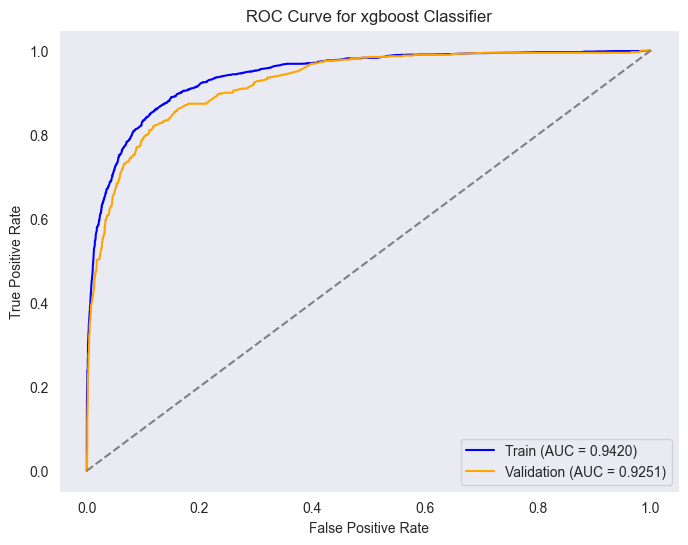

In [24]:
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    max_depth=3,
    n_estimators=10,
    enable_categorical=True,  # для категорійних ознак
    use_label_encoder=False,  # щоб уникнути попереджень, якщо використовуєте нові версії XGBoost
    missing=np.nan,  # явне вказування пропущених значень
    device='cpu'
)


xgb_clf.fit(train_inputs, train_targets)


train_pred = xgb_clf.predict(train_inputs)
val_pred = xgb_clf.predict(val_inputs)

print(classification_report(train_targets, train_pred, digits=4))
print(classification_report(val_targets, val_pred, digits=4))

plot_roc_curve(train_inputs, train_targets, val_inputs, val_targets, xgb_clf, 'xgboost')

As we can see, this model is quite good. It has low bias and quite low variance.
And its precision is comparable with the model, which I got using Decision trees.

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

100%|██████████| 20/20 [00:06<00:00,  2.96trial/s, best loss: -0.902]
Найкращі гіперпараметри:  {'colsample_bytree': 0.5710386228873152, 'gamma': 0.37641904661227316, 'learning_rate': 0.04916654562204556, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 300, 'reg_alpha': 0.8896259504048604, 'reg_lambda': 0.2879081492366977, 'subsample': 0.7640766100031156}
              precision    recall  f1-score   support

         0.0     0.9415    0.9745    0.9577      9558
         1.0     0.8842    0.7629    0.8191      2442

    accuracy                         0.9314     12000
   macro avg     0.9128    0.8687    0.8884     12000
weighted avg     0.9298    0.9314    0.9295     12000

              precision    recall  f1-score   support

         0.0     0.9206    0.9556    0.9378      2390
         1.0     0.7958    0.6770    0.7316       610

    accuracy                         0.8990      3000
   macro avg     0.8582    0.8163    0.8347      3000
weighted avg     0.8952    0.8990   

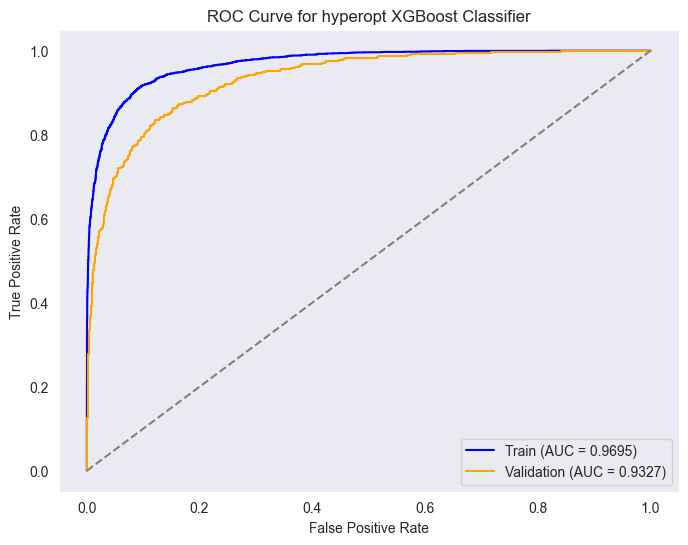

In [44]:
from sklearn.metrics import accuracy_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

def objective(params):
    clf = XGBClassifier(
    n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        gamma=params['gamma'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        enable_categorical=True,
        use_label_encoder=False,
        missing=np.nan,
        device='cpu',
        early_stopping_rounds=10
    )

    clf.fit(
        train_inputs,
        train_targets,
        eval_set=[(val_inputs, val_targets)],
        verbose=False)
    pred = clf.predict(val_inputs)
    accuracy = accuracy_score(val_targets, pred)

    return {'loss': -accuracy, 'status': STATUS_OK}

space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_xg_clf = XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
    use_label_encoder=False,
    missing=np.nan,
    device='cpu',
)

final_xg_clf.fit(train_inputs, train_targets)

train_pred = final_xg_clf.predict(train_inputs)
val_pred = final_xg_clf.predict(val_inputs)

print(classification_report(train_targets, train_pred, digits=4))
print(classification_report(val_targets, val_pred, digits=4))

plot_roc_curve(train_inputs, train_targets, val_inputs, val_targets, final_xg_clf, 'hyperopt XGBoost')

As we can see, we slightly improved our model in comparison with vanilla XGBoost.

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] categorical_feature is set with cat_feature=1,3,4, categorical_column=1,3,4 will be ignored. Current value: categorical_feature=1,3,4
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1571
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 12
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] [binary:BoostFromScore]: pavg=

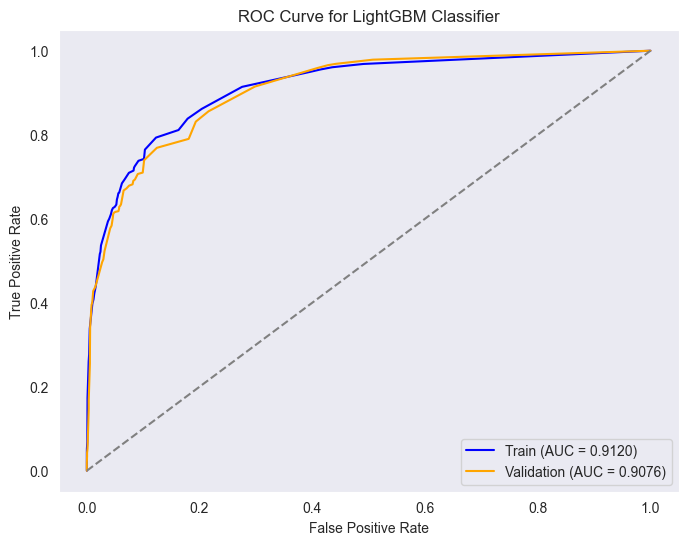

In [41]:
import lightgbm as lgb

cat_feature_indexes = [train_inputs.columns.get_loc(col) for col in cat_features]

lgb_clf = lgb.LGBMClassifier(
    max_depth=3,
    n_estimators=50,
    learning_rate=0.01,
    cat_feature=cat_feature_indexes,  # для автоматичного розпізнавання категорійних ознак
    missing=np.nan,  # явне вказування пропущених значень
)

lgb_clf.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)])

train_pred = lgb_clf.predict(train_inputs)
val_pred = lgb_clf.predict(val_inputs)

print(classification_report(train_targets, train_pred, digits=4))
print(classification_report(val_targets, val_pred, digits=4))

plot_roc_curve(train_inputs, train_targets, val_inputs, val_targets, lgb_clf, 'LightGBM')

As we can see, this model also has bow bias and quite low variance.
And it is worse than hyperopt tuned model.

5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set with cat_feature=1,3,4, categorical_column=1,3,4 will be ignored. Current value: categorical_feature=1,3,4
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1571                     
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561 
[LightGBM] [Warning] No further spli

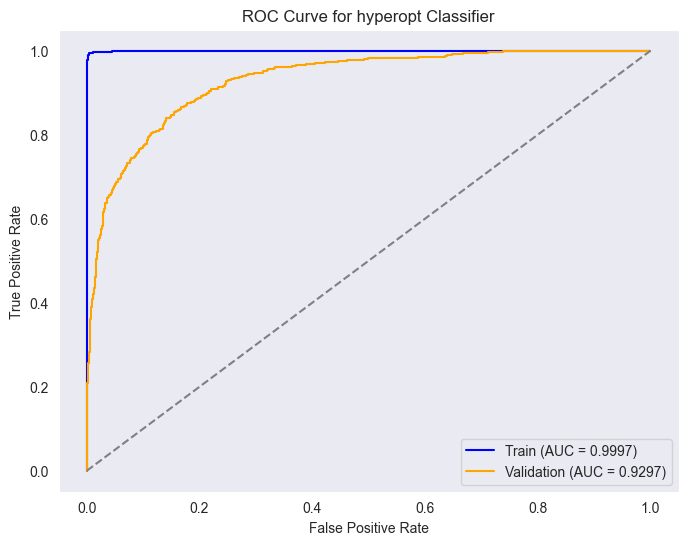

In [42]:
def objective(params):
    clf = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),  # Кількість дерев у ансамблі (кількість ітерацій бустингу)
        learning_rate=params['learning_rate'],  # Коефіцієнт, на який зменшується внесок кожного доданого дерева
        max_depth=int(params['max_depth']),  # Максимальна глибина кожного дерева
        num_leaves=int(params['num_leaves']),  # Максимальна кількість листків, що дозволяємо кожному дереву мати.
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        min_split_gain=params['min_split_gain'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        cat_feature=cat_feature_indexes  # Індекси категорійних ознак
    )

    clf.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)])
    pred = clf.predict(val_inputs)
    accuracy = accuracy_score(val_targets, pred)

    return {'loss': -accuracy, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)  # додано мінімальне зменшення втрат для поділу
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = lgb.LGBMClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    num_leaves=best['num_leaves'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_split_gain=best['min_split_gain'],
    cat_feature=cat_feature_indexes,
    missing=np.nan
)

final_clf.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)])

train_pred = final_clf.predict(train_inputs)
val_pred = final_clf.predict(val_inputs)

print(classification_report(train_targets, train_pred, digits=4))
print(classification_report(val_targets, val_pred, digits=4))

plot_roc_curve(train_inputs, train_targets, val_inputs, val_targets, final_clf, 'hyperopt')

This model showed better results than vanilla LightGBM, but it is still worse than XgBoost with hyperopt tuning.

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

In [55]:
clients_df_test = pd.read_csv('csv/test.csv')

columns_to_drop = ['id', 'Exited']
clients_df_test.drop(columns=[col for col in columns_to_drop if col in clients_df_test.columns], axis=1, inplace=True)
cat_features = clients_df_test.select_dtypes(include='object').columns
clients_df_test[cat_features] = clients_df_test[cat_features].astype('category')


test_final_xg_clf = final_xg_clf.predict_proba(clients_df_test)[:,1]
clients_df_test['Exited'] = test_final_xg_clf
submission = pd.read_csv('csv/sample_submission.csv')
submission['Exited'] = clients_df_test['Exited']
submission.to_csv('csv/submission_test_final_xg_clf.csv', index=False)

columns_to_drop = ['id', 'Exited']
clients_df_test.drop(columns=[col for col in columns_to_drop if col in clients_df_test.columns], axis=1, inplace=True)

test_final_lgb_clf = final_clf.predict_proba(clients_df_test)[:,1]
clients_df_test['Exited'] = test_final_xg_clf
submission = pd.read_csv('csv/sample_submission.csv')
submission['Exited'] = clients_df_test['Exited']
submission.to_csv('csv/submission_test_final_lgb_clf.csv', index=False)

[LightGBM] [Warning] Unknown parameter: missing


I chose to try both hyperopt trained model for my kaggle submission, because they have best scores among all model in this notebook.